In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lifetimes
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
import seaborn as sns

In [2]:
df = pd.read_parquet("transactional_dataset_train.parquet")
df.head()

,account_id,event_time,amount
0,132285932,2021-08-14 21:18:04.956,19.99
1,131792942,2021-08-14 21:28:33.266,9.99
2,180084640,2021-08-14 19:10:59.833,0.99
3,132486244,2021-08-14 20:35:14.897,9.99
4,131970262,2021-08-14 19:30:59.234,0.99


In [3]:
(df[df["account_id"]=="98491143"].event_time).to_frame()

,event_time
3751,2021-02-26 12:05:43.607
11677,2021-02-26 13:06:05.586
11683,2021-02-26 13:05:13.502
11704,2021-02-26 01:48:36.092
19592,2021-02-26 14:29:59.118
...,...
180949,2021-02-25 14:16:27.106
180960,2021-02-25 12:55:27.777
185416,2021-02-26 01:49:02.870
188867,2021-02-25 19:01:19.248


In [4]:
summary = lifetimes.utils.summary_data_from_transaction_data(df,"account_id","event_time","amount",freq='s',freq_multiplier=86400)
summary = summary.reset_index()
summary.sort_values(by="frequency",ascending = False).head()

#pomocou vstavaných funkcií packagu lifetimes som vytvoril túto tabuľku, ktorá zobrazuje frekvenciu nákupu hráčov,
#čas od posleného nákupu(recency) v dňoch, čas od prvého nákupu v dňoch a celkový spend hráčov.
#argument freq hovorí lifetimes packagu, že nemá rozlišovať len nákupy spravené v odlišné dni ale aj nákupy spravené v inú sekundu
# ako predošlý. Vyhneme sa tým tomu že ignoruje nákupy spravené v ten istý deň
#freq multiplier premení v našom prípade sekundy na dni. 


,account_id,frequency,recency,T,monetary_value
67223,98491143,103.0,2.189190,176.550914,26.718155
50591,167529481,96.0,2.891840,60.774086,12.594167
10480,113958422,88.0,1.664942,86.127986,30.058182
52280,169616730,82.0,2.894387,50.590313,34.770488
19734,123433842,80.0,2.371910,43.490475,9.152500


count    69858.000000
mean         1.304604
std          2.965060
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        103.000000
Name: frequency, dtype: float64
percentage of one time buyers 57.11


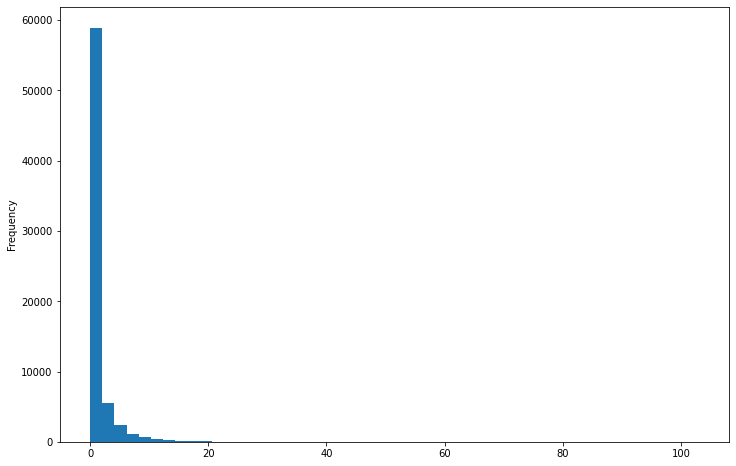

In [5]:
fig = plt.figure(figsize=(12,8))
summary["frequency"].plot(kind="hist",bins = 50)
print(summary["frequency"].describe())
percentage = sum(summary["frequency"]==0)/(len(summary))*(100)
print(f"percentage of one time buyers { round(percentage,2)}")
#základna popisná štatistika summary tabuľlky nášho datasetu plus podiel one time buyerov a jednoduchý histogram na kotorom 
#vidno početnosť zákazníkov, prevládajú hráči čo nákupili 5-krát a menej. s grafmi sa ešte určite pohrám 

In [6]:
bgf = lifetimes.BetaGeoFitter()
bgf.fit(summary["frequency"],summary["recency"],summary["T"])
# snažíme sa nafitovať BG/NBD model na naše dáta

<lifetimes.BetaGeoFitter: fitted with 69858 subjects, a: 2.93, alpha: 0.00, b: 4.07, r: 0.06>

In [7]:
bgf.summary 
#summary tabuľka s údajmi o koeficientoch BG/NBD modelu. tieto koeficienty vypočítal z historických dát
# následne ich používa pri počítaní pravdepodobností a predikovaní
#... toto si musím ešte bližšie doštudovať

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.060864,0.000412,0.060056,0.061672
alpha,0.003070,0.000080,0.002912,0.003228
a,2.929621,0.070903,2.790650,3.068591
b,4.067368,0.124858,3.822647,4.312090


In [8]:
summary["probability_alive"] = bgf.conditional_probability_alive(summary["frequency"],summary["recency"],summary["T"])
summary[summary["frequency"]>0].sort_values(by="probability_alive",ascending = False).head()
#vstavaná funkcia, ktorá vypočíta pravdepodobnosť toho, že zákazník je ešte nažive(že este nakupuje)
#v závislosti od nami zadaných parametrov(recency,frequency,T)
#pravdepodobnosti sú však veľmi malé.... 

,account_id,frequency,recency,T,monetary_value,probability_alive
36554,133513494,3.0,0.076725,0.076725,13.323333,0.674378
36569,133551363,6.0,2.042292,2.214340,8.323333,0.654822
64380,180987991,3.0,2.932812,3.137315,14.323333,0.627602
36052,133084422,8.0,2.930775,3.306019,8.365000,0.588782
36499,133456254,3.0,2.768067,3.137569,1.656667,0.585387


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

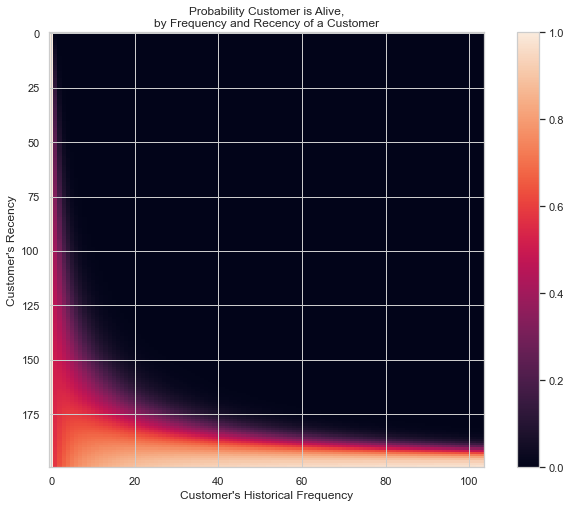

In [9]:
fig = plt.figure(figsize=(12,8))
sns.set_theme(style="whitegrid",palette="colorblind")
plot_probability_alive_matrix(bgf)
# graf pre vizualizáciu hornej tabuľky

c:\users\fpolo\appdata\local\programs\python\python39\lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:256: RuntimeWarning: overflow encountered in double_scalars
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

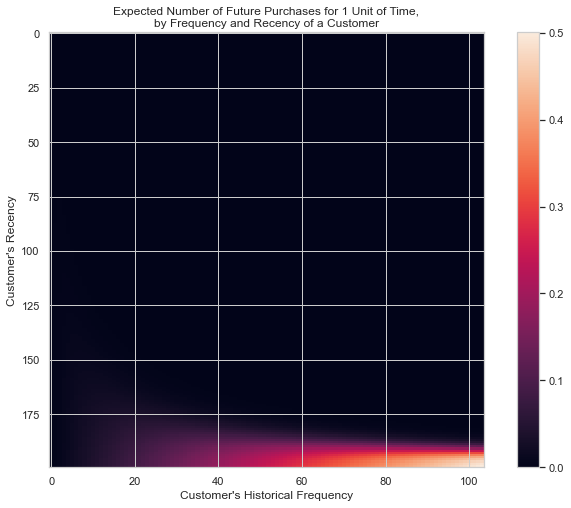

In [10]:
fig = plt.figure(figsize=(12,8))
sns.set_theme(style="whitegrid",palette="colorblind")
plot_frequency_recency_matrix(bgf)
#tento graf zobrazuje očakávané množstvo nákupov za jednu jednotku času v našom prípade sa jedná o dni
#v závislosti od recency a frequency. Tento graf síce zobrazuje Očákavané množstvo nákupov za jednu časovú jednotku
# no aj tak si myslím, že bude vhodným doplnkom k tabuľke pod touto bunkou. 
# graf je nad tabuľkou lebo po pridaní nového stĺpca nefungoval správne.

In [11]:
t=10 #ešte overím či to berie ako dni ked je celý dataset v dňoch alebo to treba špecifikovať.
summary["predicted_num_of_purchases"]=round(bgf.conditional_expected_number_of_purchases_up_to_time(10,summary["frequency"],summary["recency"],summary["T"]),2)
summary[summary["frequency"]>0].sort_values(by="probability_alive",ascending = False).head()
#vytvorenie nového stĺpca za pomoci vstavanej funkcie. táto funkcia predpovedá počet nákupov za určitý čas(prvý argument funkcie)
#pre toto predikovanie používa stĺpce frequency, recency a T(Čas od prvého nákupu)

,account_id,frequency,recency,T,monetary_value,probability_alive,predicted_num_of_purchases
36554,133513494,3.0,0.076725,0.076725,13.323333,0.674378,3.14
36569,133551363,6.0,2.042292,2.214340,8.323333,0.654822,3.61
64380,180987991,3.0,2.932812,3.137315,14.323333,0.627602,2.10
36052,133084422,8.0,2.930775,3.306019,8.365000,0.588782,3.62
36499,133456254,3.0,2.768067,3.137569,1.656667,0.585387,1.96


No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Expected Number of Repeat Purchases per Customer'}, xlabel='Time Since First Purchase'>

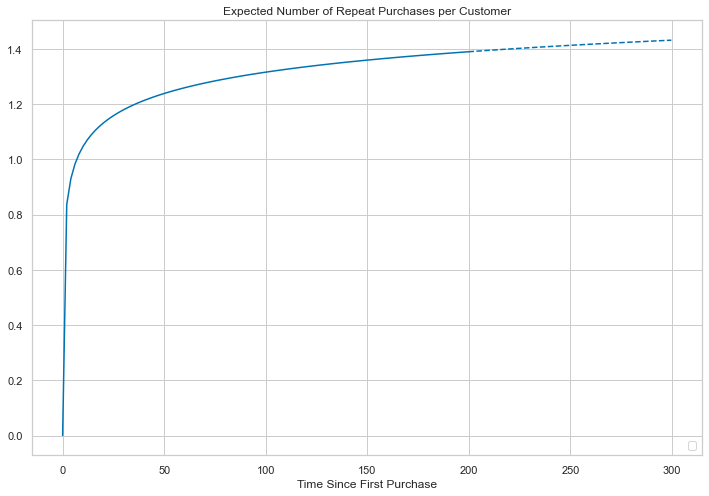

In [12]:
fig = plt.figure(figsize=(12,8))
sns.set_theme(style="whitegrid",palette="colorblind")
lifetimes.plotting.plot_expected_repeat_purchases(bgf)

# Gamma gamma model pre predpovedanie penaznej hodnoty

In [13]:
# odfiltrovanie one time buyerov
gamma_summary = summary[summary["frequency"]>0]
gamma_summary.sort_values(by="probability_alive",ascending = False).head(10)

,account_id,frequency,recency,T,monetary_value,probability_alive,predicted_num_of_purchases
36554,133513494,3.0,0.076725,0.076725,13.323333,0.674378,3.14
36569,133551363,6.0,2.042292,2.214340,8.323333,0.654822,3.61
64380,180987991,3.0,2.932812,3.137315,14.323333,0.627602,2.10
36052,133084422,8.0,2.930775,3.306019,8.365000,0.588782,3.62
36499,133456254,3.0,2.768067,3.137569,1.656667,0.585387,1.96
64327,180936061,2.0,2.704537,3.085093,14.990000,0.568792,1.49
64446,181052341,6.0,1.896447,2.187998,8.323333,0.565713,3.12
64360,180969271,4.0,1.972569,2.331088,8.740000,0.550683,2.37
64344,180952230,4.0,1.202164,1.434699,4.240000,0.540959,2.54
36376,133336564,3.0,2.818935,3.434167,8.323333,0.531057,1.72


In [14]:
#kontrola korelácie medzi frekvenciou a penaznou hodnotou vzhladom na podmienku gamma gamma modelu
#ktorá hovorí o tom, že medzi frekvenciou a penaznou hodnotou jednotlivých zákazníkov by nemal byť žiadny vzťah
#priemerná hodnota nákupu zákazníka nesmie korelovať s frekvenciou 
gamma_summary[["frequency","monetary_value"]].corr()

,frequency,monetary_value
frequency,1.000000,0.185931
monetary_value,0.185931,1.000000


In [15]:
# korelácia vyšla veľmi slabá takže túto podmienku ktorá sa ako jediná z troch dá otestovať môžeme považovať za splnenú 
# a pokračovať ďalej 
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(gamma_summary["frequency"],
        gamma_summary["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 29962 subjects, p: 2.61, q: 1.58, v: 2.09>

In [16]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,2.613708,0.021685,2.571205,2.656211
q,1.580132,0.012436,1.555757,1.604506
v,2.092974,0.022627,2.048625,2.137324


In [17]:
print(gamma_summary[gamma_summary["monetary_value"]>0].shape)
print(summary[summary["monetary_value"]>0].shape)
#len kontrola pre mňa

(29962, 7)
(29962, 7)


In [18]:
summary = summary[summary["monetary_value"]>0]
summary["exp_avg_sales"] = ggf.conditional_expected_average_profit(summary["frequency"],
                                                                   summary["monetary_value"])
summary.sort_values(by="probability_alive",ascending = False).head(10)
#funkcia sa síce volá expected average profit ale v našom prípade sa jedná o príjmy

,account_id,frequency,recency,T,monetary_value,probability_alive,predicted_num_of_purchases,exp_avg_sales
36554,133513494,3.0,0.076725,0.076725,13.323333,0.674378,3.14,13.055100
36569,133551363,6.0,2.042292,2.214340,8.323333,0.654822,3.61,8.362798
64380,180987991,3.0,2.932812,3.137315,14.323333,0.627602,2.10,13.986211
36052,133084422,8.0,2.930775,3.306019,8.365000,0.588782,3.62,8.393740
36499,133456254,3.0,2.768067,3.137569,1.656667,0.585387,1.96,2.192138
64327,180936061,2.0,2.704537,3.085093,14.990000,0.568792,1.49,14.434559
64446,181052341,6.0,1.896447,2.187998,8.323333,0.565713,3.12,8.362798
64360,180969271,4.0,1.972569,2.331088,8.740000,0.550683,2.37,8.776255
64344,180952230,4.0,1.202164,1.434699,4.240000,0.540959,2.54,4.512830
36376,133336564,3.0,2.818935,3.434167,8.323333,0.531057,1.72,8.399545


In [19]:
print(f"očakávané priemerné príjmy: {np.mean(summary['exp_avg_sales'])}")
print(f"skutočné priemerné príjmy: {np.mean(summary['monetary_value'])}")

očakávané priemerné príjmy: 6.497463024765826
skutočné priemerné príjmy: 6.044814661581698


In [20]:
summary["predicted_clv"] = ggf.customer_lifetime_value(bgf,summary["frequency"],
                                                       summary["recency"],
                                                       summary["T"],
                                                       summary["monetary_value"],
                                                       time=1,
                                                       freq='D',
                                                       discount_rate=0.01)
summary.sort_values(by="probability_alive",ascending = False).head()
#táto funkcia nám doplní predpovedanú CLV a teda nie len očakávané príjmy

,account_id,frequency,recency,T,monetary_value,probability_alive,predicted_num_of_purchases,exp_avg_sales,predicted_clv
36554,133513494,3.0,0.076725,0.076725,13.323333,0.674378,3.14,13.055100,40.634411
36569,133551363,6.0,2.042292,2.214340,8.323333,0.654822,3.61,8.362798,32.934559
64380,180987991,3.0,2.932812,3.137315,14.323333,0.627602,2.10,13.986211,36.914716
36052,133084422,8.0,2.930775,3.306019,8.365000,0.588782,3.62,8.393740,34.323531
36499,133456254,3.0,2.768067,3.137569,1.656667,0.585387,1.96,2.192138,5.396622


In [21]:
profit_margin = 0.05
summary["CLV"] = summary["predicted_clv"]*profit_margin
summary.sort_values(by="CLV",ascending = False).head()
#CLV upravené o profit margin teda aby sme braliu do úvahy zisk a nie len príjmy

,account_id,frequency,recency,T,monetary_value,probability_alive,predicted_num_of_purchases,exp_avg_sales,predicted_clv,CLV
64351,180959270,25.0,1.981435,2.298611,26.710000,0.189073,2.87,26.557930,79.137627,3.956881
36345,133293044,3.0,2.041736,3.663762,56.656667,0.257392,0.82,53.403244,56.631725,2.831586
64329,180939621,16.0,2.928252,3.307014,8.865000,0.480358,4.88,8.872725,47.111524,2.355576
36554,133513494,3.0,0.076725,0.076725,13.323333,0.674378,3.14,13.055100,40.634411,2.031721
64380,180987991,3.0,2.932812,3.137315,14.323333,0.627602,2.10,13.986211,36.914716,1.845736


<AxesSubplot:title={'center':'mean: 0.419, var: 0.030'}, xlabel='Dropout Probability p', ylabel='Density'>

<Figure size 864x576 with 0 Axes>

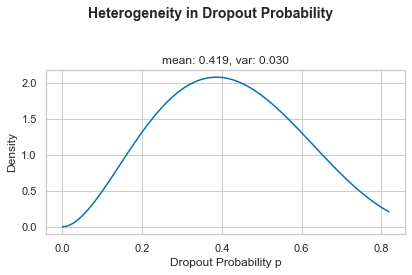

In [22]:
fig = plt.figure(figsize=(12,8))
sns.set_theme(style="whitegrid",palette="colorblind")
lifetimes.plotting.plot_dropout_rate_heterogeneity(bgf)